## Import dependencies

In [34]:
import gurobipy as gp
from gurobipy import GRB

## Prepare data

In [35]:

# --- 1. Data Preparation ---
subjects = {"A":"Anatomie", "B":"Biologie", "C":"Chirurgie", "D":"Diagnostic", "E":"Epidemiologie", "F":"Forensic", "G":"Genetique"}
weights = {"A": 8, "B": 7, "C": 7, "D": 6, "E": 6, "F": 5, "G": 6}

grades = {
    'x': {"A": 85, "B": 81, "C": 71, "D": 69, "E": 75, "F": 81, "G": 88},
    'y': {"A": 81, "B": 81, "C": 75, "D": 63, "E": 67, "F": 88, "G": 95},
    'z': {"A": 74, "B": 89, "C": 74, "D": 81, "E": 68, "F": 84, "G": 79},
    't': {"A": 74, "B": 71, "C": 84, "D": 91, "E": 77, "F": 76, "G": 73},
    'u': {"A": 72, "B": 66, "C": 75, "D": 85, "E": 88, "F": 66, "G": 93},
    'v': {"A": 71, "B": 73, "C": 63, "D": 92, "E": 76, "F": 79, "G": 93},
    'w': {"A": 79, "B": 69, "C": 78, "D": 76, "E": 67, "F": 84, "G": 79},
    'w_prime': {"A": 57, "B": 76, "C": 81, "D": 76, "E": 82, "F": 86, "G": 77},
    'a1': {"A": 89, "B": 74, "C": 81, "D": 68, "E": 84, "F": 79, "G": 77},
    'a2': {"A": 71, "B": 84, "C": 91, "D": 79, "E": 78, "F": 73.5, "G": 77},
}

## Compute pros, cons and deltas

In [36]:
def compute_pros_cons_deltas(grades_x, grades_y, subjects = subjects, weights = weights):
    # Calculate Contributions (deltas)
    deltas = {}
    pros = []
    cons = []

    for s in subjects.keys():
        # Contribution = weight * (grade_x - grade_y)
        diff = grades_x[s] - grades_y[s]
        contrib = weights[s] * diff
        deltas[s] = contrib
        
        if contrib > 0:
            pros.append(s)
        elif contrib < 0:
            cons.append(s)


    return pros, cons, deltas

In [37]:
pros, cons, deltas = compute_pros_cons_deltas(grades['x'], grades['y'])

print(f"\nPros: {pros}")
print(f"Cons: {cons}")


Pros: ['A', 'D', 'E']
Cons: ['C', 'F', 'G']


## Enumerate all 1-1 trade-offs

In [38]:
# Enumerate all valid 1-1 trade-offs
for pro in pros:
    for con in cons:
        if deltas[pro] + deltas[con] > 0:
            print(f"Trade-off: {pro} (delta={deltas[pro]}) can compensate for {con} (delta={deltas[con]})")

Trade-off: A (delta=32) can compensate for C (delta=-28)
Trade-off: D (delta=36) can compensate for C (delta=-28)
Trade-off: D (delta=36) can compensate for F (delta=-35)
Trade-off: E (delta=48) can compensate for C (delta=-28)
Trade-off: E (delta=48) can compensate for F (delta=-35)
Trade-off: E (delta=48) can compensate for G (delta=-42)


## Question 1: Create 1-1 TradeOffs

In [39]:
def explanation_1_1(pros, cons, deltas):
    # Create a new model
    m = gp.Model("Explanation_1_1")

    # Decision Variables: x[p, c] = 1 if pro p explains con c
    x = {}

    # Only create variables for VALID trade-offs (where delta_p + delta_c >= 0)
    # This implicitly handles the "strength" constraint
    for p in pros:
        for c in cons:
            if deltas[p] + deltas[c] >= 0:
                x[p, c] = m.addVar(vtype=GRB.BINARY, name=f"match_{p}_{c}")

    # Update model to integrate variables
    m.update()

    # Constraint 1: Every CON must be covered exactly once
    for c in cons:
        m.addConstr(gp.quicksum(x[p, c] for p in pros if (p, c) in x) == 1, name=f"cover_{c}")

    # Constraint 2: Every PRO can be used at most once
    for p in pros:
        m.addConstr(gp.quicksum(x[p, c] for c in cons if (p, c) in x) <= 1, name=f"use_once_{p}")

    # Objective: Just find a feasible solution. 
    # (Gurobi will try to satisfy constraints. If impossible, it returns Infeasible)
    m.setObjective(0, GRB.MINIMIZE)

    # Optimize
    m.optimize()
    return m, x

In [40]:
explanation_1_1(pros, cons, deltas)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2755059 - for non-commercial use only - registered to ma___@student-cs.fr
Optimize a model with 6 rows, 6 columns and 12 nonzeros (Min)
Model fingerprint: 0x0ba5136a
Model has 0 linear objective coefficients
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 14 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


(<gurobi.Model MIP instance Explanation_1_1: 6 constrs, 6 vars, Parameter changes: LicenseID=2755059>,
 {('A', 'C'): <gurobi.Var match_A_C (value 1.0)>,
  ('D', 'C'): <gurobi.Var match_D_C (value 0.0)>,
  ('D', 'F'): <gurobi.Var match_D_F (value 1.0)>,
  ('E', 'C'): <gurobi.Var match_E_C (value 0.0)>,
  ('E', 'F'): <gurobi.Var match_E_F (value 0.0)>,
  ('E', 'G'): <gurobi.Var match_E_G (value 1.0)>})

## Print out results

In [41]:
def print_results(m, x):
    if m.status == GRB.OPTIMAL:
        print("\n--- Explanation Found (Type 1-1) ---")
        for p in pros:
            for c in cons:
                if (p, c) in x and x[p, c].X > 0.5:
                    print(f"Trade-off: Because {p} (+{deltas[p]}) compensates for {c} ({deltas[c]})")
    elif m.status == GRB.INFEASIBLE:
        print("\nNo (1-1) explanation exists for this comparison.")
        # Optional: Calculate IIS to see which constraints failed
        m.computeIIS()
        m.write("model.ilp")
        print("Certificate of non-existence written to model.ilp")

## Show limits of current model

The pair w, w' has no solution even though we have w > w'

In [42]:
pros, cons, deltas = compute_pros_cons_deltas(grades['w'], grades['w_prime'])

m, x = explanation_1_1(pros, cons, deltas)

print_results(m, x)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2755059 - for non-commercial use only - registered to ma___@student-cs.fr
Optimize a model with 6 rows, 5 columns and 10 nonzeros (Min)
Model fingerprint: 0xb9c32c49
Model has 0 linear objective coefficients
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 14 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

No (1-1) explanation exists for this comparison.
Academic license 2755059 - for non-commercial use only - register

This is explained because there is fewer cons than pros.

In [43]:
print("Pros: ", pros)
print("Cons: ", cons)

Pros:  ['A', 'G']
Cons:  ['B', 'C', 'E', 'F']


## Question 2: 1-m Tradeoffs

In [44]:
def explanation_1_m(pros, cons, deltas):
    m = gp.Model("Explanation_1_m")

    # Decision Variables: x[p, c] = 1 if pro p covers con c
    # Note: We create variables for ALL pairs now, because validity depends on the SUM, not individual pairs.
    x = {}
    for p in pros:
        for c in cons:
            x[p, c] = m.addVar(vtype=GRB.BINARY, name=f"match_{p}_{c}")

    m.update()

    # Constraint 1: Every CON must be covered exactly once
    for c in cons:
        m.addConstr(gp.quicksum(x[p, c] for p in pros) == 1, name=f"cover_{c}")

    # Constraint 2: Trade-off Strength
    # For each Pro, its weight + sum of weights of assigned Cons >= 0
    # (Remember deltas for cons are negative, so we ADD them)
    for p in pros:
        m.addConstr(
            deltas[p] + gp.quicksum(deltas[c] * x[p, c] for c in cons) >= 0,
            name=f"strength_{p}"
        )

    # Objective: Find any feasible solution
    m.setObjective(0, GRB.MINIMIZE)

    # Optimize
    m.optimize()

    return m, x

In [45]:
pros, cons, deltas = compute_pros_cons_deltas(grades['w'], grades['w_prime'])

m, x = explanation_1_m(pros, cons, deltas)

print_results(m, x)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2755059 - for non-commercial use only - registered to ma___@student-cs.fr
Optimize a model with 6 rows, 8 columns and 16 nonzeros (Min)
Model fingerprint: 0xfafa31bf
Model has 0 linear objective coefficients
Variable types: 0 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 14 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

--- Explanation Found (Type 1-1) ---
Trade-off: Because A (

## Show current model limits again : u > v

The u > v cannot be explained by the current 1-m model.

This is because the differences between u and v cannot be explained by any single "pro" offset alone.
More exactly, if the F con can be explained only by the E pro, and E pro cannot explain any other con added to F, so we have to pair E and F. The remaining D con cannot be explained by any of the remaining pro.

In [46]:
pros, cons, deltas = compute_pros_cons_deltas(grades['u'], grades['v'])

m, x = explanation_1_m(pros, cons, deltas)

print_results(m, x)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2755059 - for non-commercial use only - registered to ma___@student-cs.fr
Optimize a model with 6 rows, 9 columns and 18 nonzeros (Min)
Model fingerprint: 0x1e9af7b9
Model has 0 linear objective coefficients
Variable types: 0 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 4 rows and 8 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 14 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

No (1-1) explanation exists for this comparison.
Academic license 2755059 - for non-commercial use only - register

## Question 3: m-1 Tradeoffs

In [47]:
def explanation_m_1(pros, cons, deltas):
    m = gp.Model("Explanation_m_1")

    # Decision Variables: x[p, c] = 1 if pro p covers con c
    # Note: We create variables for ALL pairs now, because validity depends on the SUM, not individual pairs.
    x = {}
    for p in pros:
        for c in cons:
            x[p, c] = m.addVar(vtype=GRB.BINARY, name=f"match_{p}_{c}")

    m.update()

    # Constraint 1 (Disjoint Pros): Each Pro p is used AT MOST once
    for p in pros:
        m.addConstr(gp.quicksum(x[p, c]
                    for c in cons) <= 1, name=f"pro_disjoint_{p}")

    # Constraint 2 (Cons Coverage): Each Con c must be covered AT LEAST once
    # (Since Pros are disjoint, this ensures it's the target of exactly one trade-off)
    for c in cons:
        m.addConstr(gp.quicksum(x[p, c] for p in pros) >= 1, name=f"cover_{c}")

    # Constraint 3 (Trade-off Strength, m-1): Sum of Pros covering c must dominate c
    for c in cons:
        m.addConstr(
            gp.quicksum(deltas[p] * x[p, c] for p in pros) + deltas[c] >= 0,
            name=f"strength_{c}"
        )
    
    # Objective: Find any feasible solution
    # m.setObjective(0, GRB.MINIMIZE)
    m.setObjective(gp.quicksum(x[p, c]for p in pros for c in cons), GRB.MINIMIZE)
    # Optimize
    m.optimize()

    return m, x

## Let's find a solution to y > z

In [48]:

pros, cons, deltas = compute_pros_cons_deltas(grades['y'], grades['z'])

m, x = explanation_m_1(pros, cons, deltas)

print_results(m, x)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2755059 - for non-commercial use only - registered to ma___@student-cs.fr
Optimize a model with 10 rows, 12 columns and 36 nonzeros (Min)
Model fingerprint: 0xf598dcf8
Model has 12 linear objective coefficients
Variable types: 0 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 4.0000000
Presolve removed 10 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 14 available processors)

Solution count 1: 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+00

## Let's find limits again to our current model :  z > t

Our current m-1 model cannot explain the z > t.

- For m-1:
If B is used to explain C (the biggest con, but this reasoning also works if we start by choosing D and E), then the remaining cons are D and E. Both of these cons can't be explained by a single pro, so if we pair for example D with F and G then there won't be any pro left to explain E, so we won't be able to find an explanation with only m-1 tradeoffs.

- For 1-m:
Only B can explain C, D, and E. B can explain only C or D and E. Whichever pair we choose (B, C) or (B, (D, E)), the remaining cons won't be able to be explained by a single remaining pro (F or G) so we won't be able to find an explanation with only 1-m tradeoffs.

- 1-m and m-1 explanation:
The correct combination that works for this problem is: (B, (D, E)), ((F, G), C) which contains one 1-m and one m-1.

In [49]:
pros, cons, deltas = compute_pros_cons_deltas(grades['z'], grades['t'])

m, x = explanation_m_1(pros, cons, deltas)

print_results(m, x)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2755059 - for non-commercial use only - registered to ma___@student-cs.fr
Optimize a model with 9 rows, 9 columns and 27 nonzeros (Min)
Model fingerprint: 0x1de56904
Model has 9 linear objective coefficients
Variable types: 0 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
Presolve removed 4 rows and 6 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 14 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

No (1-1) explanation exists for this comparison.
Academic license 2755059 - for non-commercial use only - register

## Question 4: Combined approaches

In [50]:
def explanation_combined(pros, cons, deltas, show=1):
    m = gp.Model("Explanation_Combined")
    m.setParam('OutputFlag', show)
    # --- Variables ---
    # x[p,c]: Link in a (1-m) trade-off (Pro p is the Center)
    x = m.addVars(pros, cons, vtype=GRB.BINARY, name="x_1m")
    
    # y[p,c]: Link in a (m-1) trade-off (Con c is the Center)
    y = m.addVars(pros, cons, vtype=GRB.BINARY, name="y_m1")

    # u[p]: Is Pro p a Center for a (1-m) trade-off?
    u = m.addVars(pros, vtype=GRB.BINARY, name="is_1m_center")
    
    # v[c]: Is Con c a Center for a (m-1) trade-off?
    v = m.addVars(cons, vtype=GRB.BINARY, name="is_m1_center")

    m.update()

    # --- Constraints ---

    # 1. Pro Usage: A pro is either a (1-m) center OR a (m-1) helper (for at most one con)
    for p in pros:
        m.addConstr(u[p] + gp.quicksum(y[p, c] for c in cons) <= 1, name=f"pro_usage_{p}")

    # 2. Con Coverage: A con is either covered by one (1-m) center OR is itself a (m-1) center
    for c in cons:
        m.addConstr(gp.quicksum(x[p, c] for p in pros) + v[c] == 1, name=f"con_coverage_{c}")

    # 3. Logical Consistency (Link x/y to u/v)
    for p in pros:
        for c in cons:
            # If p covers c in 1-m, p must be a 1-m center
            m.addConstr(x[p, c] <= u[p], name=f"link_x_u_{p}_{c}")
            # If p covers c in m-1, c must be a m-1 center
            m.addConstr(y[p, c] <= v[c], name=f"link_y_v_{p}_{c}")

    # 4. Strength: (1-m) Groups
    # If u[p]=1, Delta(p) + Sum(Delta(c)) >= 0
    for p in pros:
        m.addConstr(
            deltas[p] * u[p] + gp.quicksum(deltas[c] * x[p, c] for c in cons) >= 0,
            name=f"strength_1m_{p}"
        )

    # 5. Strength: (m-1) Groups
    # If v[c]=1, Delta(c) + Sum(Delta(p)) >= 0
    for c in cons:
        m.addConstr(
            deltas[c] * v[c] + gp.quicksum(deltas[p] * y[p, c] for p in pros) >= 0,
            name=f"strength_m1_{c}"
        )

    # Objective: Minimize complexity (number of edges) or just find feasible
    m.setObjective(0, GRB.MINIMIZE)

    m.optimize()
    
    return m, x, y, u, v

In [51]:
def print_results_combined(m, x, y, u, v, pros, cons, deltas):
    # --- Printer ---
    if m.status == GRB.OPTIMAL:
        print("\n=== Combined Explanation Found ===")
        
        # Print (1-m) parts
        for p in pros:
            if u[p].X > 0.5:
                covered_cons = [c for c in cons if x[p,c].X > 0.5]
                score_balance = deltas[p] + sum(deltas[c] for c in covered_cons)
                print(f"[Type 1-m] Pro {p} (+{deltas[p]}) covers Cons {covered_cons} (Balance: {score_balance})")

        # Print (m-1) parts
        for c in cons:
            if v[c].X > 0.5:
                helping_pros = [p for p in pros if y[p,c].X > 0.5]
                score_balance = deltas[c] + sum(deltas[p] for p in helping_pros)
                print(f"[Type m-1] Con {c} ({deltas[c]}) is covered by Pros {helping_pros} (Balance: {score_balance})")

    elif m.status == GRB.INFEASIBLE:
        print("No combined explanation exists.")

In [52]:
# --- Test on z > t (which requires combined explanation) ---
print("\n--- Testing Combined Model on z > t ---")
pros, cons, deltas = compute_pros_cons_deltas(grades['z'], grades['t'])
m, x, y, u, v = explanation_combined(pros, cons, deltas)
print_results_combined(m, x, y, u, v, pros, cons, deltas)


--- Testing Combined Model on z > t ---
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2755059 - for non-commercial use only - registered to ma___@student-cs.fr
Optimize a model with 30 rows, 24 columns and 84 nonzeros (Min)
Model fingerprint: 0xf8d46187
Model has 0 linear objective coefficients
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 30 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 14 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Bes

## a1-a2 tradeoffs using 1-m or m-1

There is no explanation of type (1-m) or (m-1) for $a_1 > a_2$.
While $a_1$ is strictly better than $a_2$, the margin is extremely thin (Total Score Difference = $+1.5$).
The model requires partitioning arguments into disjoint sets where every set is positive.
The only Pro strong enough to cover the large Cons (B, C, or D) is attribute A ($+144$).

Using A to cover any single Con (e.g., B: $-70$) creates a surplus of $+74$ ($144 - 70$).
This surplus ($+74$) is "wasted" because it cannot be transferred to help other groups.
Since the wasted surplus exceeds the total global margin ($74 > 1.5$), the remaining Pros are mathematically insufficient to cover the remaining Cons1.

The strict "disjoint sets" constraint fails when the global score difference is smaller than the "surplus" generated by the necessary trade-offs (a classic "Bin Packing" inefficiency).

In [53]:
pros, cons, deltas = compute_pros_cons_deltas(grades['a1'], grades['a2'])
m, x, y, u, v = explanation_combined(pros, cons, deltas)
print_results_combined(m, x, y, u, v, pros, cons, deltas)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G419)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2755059 - for non-commercial use only - registered to ma___@student-cs.fr
Optimize a model with 30 rows, 24 columns and 84 nonzeros (Min)
Model fingerprint: 0xebb726af
Model has 0 linear objective coefficients
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 17 rows and 20 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 14 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
No combined explanation exists.


# Application to real datasets

The ranking is established using a peel-off strategy based on iterative pairwise comparisons: in each cycle, all non-dominated instances (those that cannot be surpassed by any remaining instance through a valid trade-off explanation) are assigned the current rank and removed from the set; this process repeats until every instance has been classified into a hierarchical level.

In [54]:
from tqdm import tqdm

def get_ranking(instances, weights, subjects):
    """
    Trie les instances par rang en utilisant le modèle d'explication combiné.
    """
    keys = list(instances.keys())
    n = len(keys)

    # Adjacency matrix: adj[i][j] = True si i explique sa supériorité sur j
    adj = {k: [] for k in keys}
    in_degree = {k: 0 for k in keys}

    print(f"Analyse des comparaisons pour {n} instances...")

    for i in tqdm(range(n)):
        for j in range(n):
            if i == j:
                continue

            p1, p2 = keys[i], keys[j]
            pros, cons, deltas = compute_pros_cons_deltas(
                instances[p1], instances[p2], subjects=subjects, weights=weights)

            # On vérifie si une explication combinée existe
            m, _, _, _, _ = explanation_combined(pros, cons, deltas, show=0)

            if m.status == GRB.OPTIMAL:
                adj[p1].append(p2)
                in_degree[p2] += 1
    print(adj)
    # Algorithme de classement par niveaux (Peel-off strategy)
    current_keys = set(keys)
    rankings = []

    while current_keys:
        # Trouver toutes les instances qui n'ont pas de "supérieur" dans le set actuel
        level = [k for k in current_keys if not any(
            k in adj[other] for other in current_keys if other != k)]

        if not level:  # Cas de cycle ou blocage total
            rankings.append(list(current_keys))
            break

        rankings.append(level)
        current_keys -= set(level)

    return rankings, adj

## Import of the data

We use pyexcel with a custom function to import the data from te various datasets

In [55]:
import pyexcel as pe


def load_data_from_config(config):
    """
    Charge les données depuis Excel ou CSV selon la configuration.
    Gère les cas sans poids (CSV) et sans colonne de nom explicite.
    """
    print(f"Chargement de : {config['file_name']}")

    # 1. Lecture générique (Excel ou CSV)
    try:
        book = pe.get_book(file_name=config['file_name'])
        # On prend toujours la première feuille (compatible CSV et Excel)
        if isinstance(book, pe.Sheet):
            sheet = book
        else:
            sheet = book[0]
        rows = list(sheet)
    except Exception as e:
        print(f"❌ Erreur de lecture : {e}")
        return {}, {}, None

    # 2. Récupération de l'en-tête
    header_row = rows[config['header_idx']]

    subjects = {}
    weights = {}  # Sera remplacé par None si demandé
    valid_col_indices = []

    # 3. Extraction des métadonnées
    col_start = config['col_start_idx']

    # Cas A : Les poids sont fournis (Excel RATP / 27 Critères)
    if config['weight_idx'] is not None:
        weight_row = rows[config['weight_idx']]
        current_code_idx = 0
        for col_idx in range(col_start, len(header_row)):
            # Sécurité : on ne prend que si on a un Nom ET un Poids
            if col_idx < len(weight_row) and str(header_row[col_idx]).strip() and str(weight_row[col_idx]).strip():
                code = f"C{current_code_idx}"
                subjects[code] = str(header_row[col_idx]).strip()
                weights[code] = float(weight_row[col_idx])
                valid_col_indices.append((code, col_idx))
                current_code_idx += 1

    # Cas B : Pas de poids (CSV Breast Cancer)
    else:
        weights = None  # Consigne explicite
        current_code_idx = 0
        for col_idx in range(col_start, len(header_row)):
            subj_name = str(header_row[col_idx]).strip()
            if subj_name:
                code = f"C{current_code_idx}"
                subjects[code] = subj_name
                # On garde l'index pour lire les données
                valid_col_indices.append((code, col_idx))
                current_code_idx += 1

    # 4. Extraction des Données
    data = {}
    end_idx = config.get('data_end_idx', len(rows))
    start_idx = config['data_start_idx']

    # Logique pour le nom de l'item
    use_auto_index = (config.get('name_col_idx') is None)

    count = 0
    for i, row_idx in enumerate(range(start_idx, end_idx)):
        if row_idx >= len(rows):
            break
        row = rows[row_idx]

        # Détermination du nom
        if use_auto_index:
            item_name = f"{count}"
        else:
            item_name = str(row[config['name_col_idx']]).strip()

        if item_name:  # Si la ligne n'est pas vide
            item_grades = {}
            for code, col_idx in valid_col_indices:
                try:
                    # Gestion robuste des valeurs (vide ou string -> 0.0)
                    val = row[col_idx] if col_idx < len(row) else 0.0
                    item_grades[code] = float(val) if val != '' else 0.0
                except:
                    item_grades[code] = 0.0

            data[item_name] = item_grades
            count += 1

    print(f"✅ {len(data)} éléments chargés avec {len(subjects)} critères.")
    return subjects, data, weights

In [56]:
# ==========================================
# CONFIGURATION DES DATASETS
# ==========================================

config_ratp = {
    'file_name': "data/RATP.xlsx",
    'sheet_name': "Feuil1",
    'header_idx': 2,       # Ligne "Metro station" [cite: 2]
    'weight_idx': 11,      # Ligne "weights" [cite: 2]
    'data_start_idx': 3,   # Début des stations [cite: 2]
    'data_end_idx': 11,    # Fin des stations (avant les poids)
    'name_col_idx': 1,     # Colonne B (Nom station)
    'col_start_idx': 2     # Colonne C (Première note)
}

config_bc = {
    'file_name': "data/breastcancer_processed.csv",
    # Pas de sheet_name nécessaire avec la nouvelle logique book[0]

    'header_idx': 0,       # Ligne 1 : "Benign","ClumpThickness"...
    'weight_idx': None,    # PAS de poids

    'data_start_idx': 1,   # Ligne 2 : Les données commencent tout de suite
    'data_end_idx': 1000,  # Lire tout le fichier (ou mettre une limite)

    # PAS de colonne ID unique -> On génère "Patient_0", etc.
    'name_col_idx': None,
    # On saute la col 0 ("Benign") qui est la classe, on commence à "ClumpThickness"
    'col_start_idx': 1
}

config_27 = {
    'file_name': "data/data27crit.xlsx",
    'sheet_name': "Feuil1",
    'header_idx': 4,       # Ligne "a,b,c..." [cite: 3]
    'weight_idx': 5,       # Ligne "weight..." [cite: 3]
    'data_start_idx': 7,   # Début "solution 1" [cite: 3]
    'data_end_idx': 11,    # Fin après solution 4
    'name_col_idx': 0,     # Colonne A
    'col_start_idx': 1     # Colonne B
}

## RATP Dataset

In [57]:
subjects, data, weights = load_data_from_config(config_ratp)
results, adj = get_ranking(data, weights, subjects)

# Affichage propre
for i, rank in enumerate(results):
    print(f"Rang {i+1}: {rank}")

Chargement de : data/RATP.xlsx
✅ 8 éléments chargés avec 7 critères.
Analyse des comparaisons pour 8 instances...


100%|██████████| 8/8 [00:00<00:00, 233.07it/s]

{'Odéon (Ligne 4)': ["Place d'Italie (Lign 6)", 'Jussieu (Ligne 7)', 'Nation (Ligne 9)', 'La Motte Picquet-Grenelle (Ligne 10)', "Porte d'Orléans (Ligne 4)", 'Daumenil (Ligne 6)', 'Vaugirard (Ligne 12)'], "Place d'Italie (Lign 6)": ['Jussieu (Ligne 7)', 'Nation (Ligne 9)', 'La Motte Picquet-Grenelle (Ligne 10)', "Porte d'Orléans (Ligne 4)", 'Daumenil (Ligne 6)', 'Vaugirard (Ligne 12)'], 'Jussieu (Ligne 7)': ['La Motte Picquet-Grenelle (Ligne 10)', "Porte d'Orléans (Ligne 4)", 'Vaugirard (Ligne 12)'], 'Nation (Ligne 9)': ['Jussieu (Ligne 7)', 'La Motte Picquet-Grenelle (Ligne 10)', "Porte d'Orléans (Ligne 4)", 'Vaugirard (Ligne 12)'], 'La Motte Picquet-Grenelle (Ligne 10)': ["Porte d'Orléans (Ligne 4)", 'Vaugirard (Ligne 12)'], "Porte d'Orléans (Ligne 4)": ['Vaugirard (Ligne 12)'], 'Daumenil (Ligne 6)': ['Jussieu (Ligne 7)', 'Nation (Ligne 9)', 'La Motte Picquet-Grenelle (Ligne 10)', "Porte d'Orléans (Ligne 4)", 'Vaugirard (Ligne 12)'], 'Vaugirard (Ligne 12)': []}
Rang 1: ['Odéon (Ligne

In [58]:
for i in range(len(results)-1):
    print(f"\nRank {i+1} vs {i+2}")
    pros, cons, deltas = compute_pros_cons_deltas(data[results[i][0]], data[results[i+1][0]], subjects=subjects, weights=weights)
    m, x, y, u, v = explanation_combined(pros, cons, deltas, show=0)
    print_results_combined(m, x, y, u, v, pros, cons, deltas)


Rank 1 vs 2

=== Combined Explanation Found ===
[Type 1-m] Pro C0 (+336000000.0) covers Cons ['C2', 'C6'] (Balance: 267999405.0)
[Type 1-m] Pro C3 (+990000.0) covers Cons [] (Balance: 990000.0)
[Type m-1] Con C5 (-22.120000000000033) is covered by Pros ['C4'] (Balance: 569.88)

Rank 2 vs 3

=== Combined Explanation Found ===
[Type 1-m] Pro C0 (+168000000.0) covers Cons ['C2', 'C3'] (Balance: 114855000.0)
[Type 1-m] Pro C1 (+9480000.0) covers Cons [] (Balance: 9480000.0)

Rank 3 vs 4

=== Combined Explanation Found ===
[Type 1-m] Pro C0 (+420000000.0) covers Cons ['C1', 'C2', 'C3', 'C4'] (Balance: 313944260.0)

Rank 4 vs 5

=== Combined Explanation Found ===
[Type 1-m] Pro C2 (+170000000.0) covers Cons ['C1', 'C5', 'C6'] (Balance: 155779464.72)
[Type 1-m] Pro C3 (+1650000.0) covers Cons [] (Balance: 1650000.0)
[Type 1-m] Pro C4 (+666.0) covers Cons [] (Balance: 666.0)

Rank 5 vs 6

=== Combined Explanation Found ===
[Type m-1] Con C3 (-660000.0) is covered by Pros ['C1'] (Balance: 1040

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


def plot_dominance_matrix(adj, order):
    """
    Trace la matrice d'adjacence à partir du dictionnaire 'adj' :
    - Rouge : La ligne domine la colonne (1)
    - Bleu : La ligne ne domine pas la colonne (0)
    """
    # Extraction des noms des instances (clés du dictionnaire)
    keys = order
    n = len(keys)

    # Initialisation de la matrice numérique
    matrix = np.zeros((n, n))
    key_to_idx = {k: i for i, k in enumerate(keys)}

    # Remplissage de la matrice à partir des relations du dictionnaire adj
    for source, targets in adj.items():
        for target in targets:
            if target in key_to_idx:
                matrix[key_to_idx[source]][key_to_idx[target]] = 1

    # Configuration de la figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Création de la colormap personnalisée [0: Bleu, 1: Rouge]
    cmap = mcolors.ListedColormap(['blue', 'red'])

    # Affichage de la matrice
    # L'origine 'upper' place la première ligne en haut
    im = ax.imshow(matrix, cmap=cmap, origin='upper')

    # Configuration des axes
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(keys)
    ax.set_yticklabels(keys)

    # Rotation des étiquettes de l'axe X pour la lisibilité
    plt.setp(ax.get_xticklabels(), rotation=45,
             ha="right", rotation_mode="anchor")

    # Ajout des étiquettes numériques (0 ou 1) dans chaque cellule
    for i in range(n):
        for j in range(n):
            ax.text(j, i, int(matrix[i, j]), ha="center", va="center",
                    color="white", fontweight='bold')

    # Titres et labels
    ax.set_title("Matrice d'Adjacence (Rouge = Dominant, Bleu = Non-Dominant)")
    ax.set_ylabel("Source (Instance Dominante)")
    ax.set_xlabel("Cible (Instance Dominée)")

    fig.tight_layout()
    plt.show()

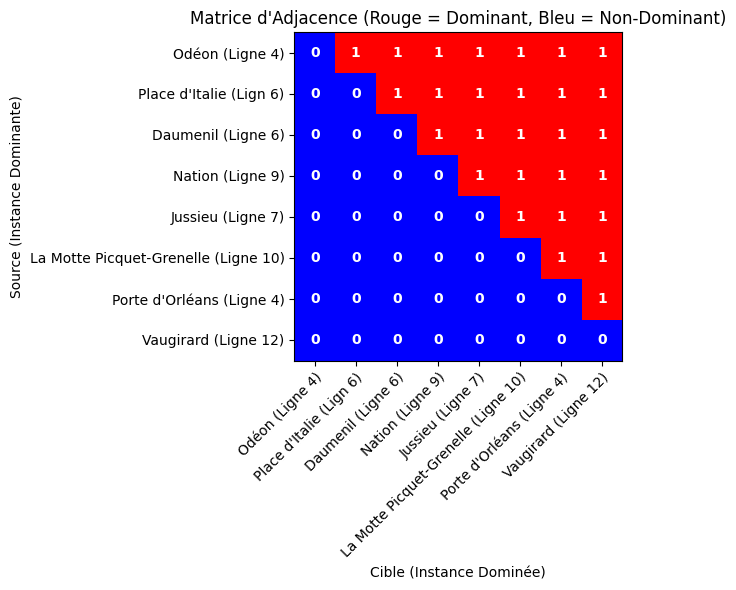

In [60]:
plot_dominance_matrix(adj, [res[0] for res in results])

# Breast Cancer Application

We do a logistic regression to classify breast cancers as begign or not. We therefore obtain weights for each column (the weight in the logistic regression), and we will use these weights to compare patients and explain why a cancer is more or less begign than another.

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

file_path = 'data/breastcancer_processed.csv'
df = pd.read_csv(file_path)

X = df.drop('Benign', axis=1)
y = df['Benign']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

weights = dict(zip(X.columns, model.coef_[0]))

accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2%}")
print("\nFeature Weights:")
print(weights)

Model Accuracy: 95.62%

Feature Weights:
{'ClumpThickness': np.float64(0.4520387904812578), 'UniformityOfCellSize': np.float64(-0.05009447341724716), 'UniformityOfCellShape': np.float64(0.3631128571312812), 'MarginalAdhesion': np.float64(0.2887232292820473), 'SingleEpithelialCellSize': np.float64(0.06245765920551566), 'BareNuclei': np.float64(0.36174898819828205), 'BlandChromatin': np.float64(0.5103530473908044), 'NormalNucleoli': np.float64(0.19432124333217393), 'Mitoses': np.float64(0.3818719219669679)}


In [62]:
data_dict = X.to_dict(orient='index')

print(data_dict[0])

{'ClumpThickness': 5, 'UniformityOfCellSize': 1, 'UniformityOfCellShape': 1, 'MarginalAdhesion': 1, 'SingleEpithelialCellSize': 2, 'BareNuclei': 1, 'BlandChromatin': 3, 'NormalNucleoli': 1, 'Mitoses': 1}


In [63]:
subjects, data, _ = load_data_from_config(config_bc)

Chargement de : data/breastcancer_processed.csv
✅ 683 éléments chargés avec 9 critères.


In [64]:
new_weights = {}
for key, value in subjects.items():
    new_weights[key] = weights[value]
weights = new_weights

In [31]:
def analyze_explainability(adj, keys):
    """
    Calculates the proportion of pairs that are non-explainable.
    A pair (i, j) is non-explainable if neither i > j nor j > i can be explained.
    """
    n = len(keys)
    # Total number of unique unordered pairs: n * (n - 1) / 2
    total_unique_pairs = n * (n - 1) // 2
    
    non_explainable_pairs = []
    
    # Iterate through all unique pairs (i, j)
    for i in range(n):
        for j in range(i + 1, n):
            p1, p2 = keys[i], keys[j]
            
            # Check if p1 explains superiority over p2
            p1_over_p2 = p2 in adj[p1]
            # Check if p2 explains superiority over p1
            p2_over_p1 = p1 in adj[p2]
            
            # If neither is true, the pair is non-explainable
            if not p1_over_p2 and not p2_over_p1:
                non_explainable_pairs.append((p1, p2))
                
    proportion = len(non_explainable_pairs) / total_unique_pairs if total_unique_pairs > 0 else 0
    
    return proportion, non_explainable_pairs

results, adj = get_ranking(data, weights, subjects)
keys = list(data.keys())

prop, pairs = analyze_explainability(adj, keys)

print(f"\n--- Statistics ---")
print(f"Total possible unique pairs: {len(keys) * (len(keys) - 1) // 2}")
print(f"Number of non-explainable pairs: {len(pairs)}")
print(f"Proportion of non-explainable pairs: {prop:.2%}")

if pairs:
    print("\nList of non-explainable pairs:")
    for p1, p2 in pairs:
        print(f" - {p1} vs {p2}")

Analyse des comparaisons pour 683 instances...


100%|██████████| 683/683 [02:03<00:00,  5.55it/s]


{'0': ['2', '7', '8', '9', '10', '11', '13', '16', '17', '22', '23', '25', '26', '27', '28', '29', '30', '32', '33', '34', '43', '45', '59', '62', '64', '67', '73', '74', '75', '76', '77', '79', '80', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '100', '106', '113', '116', '117', '118', '119', '123', '125', '127', '129', '131', '132', '134', '135', '136', '137', '138', '140', '141', '143', '146', '149', '150', '152', '153', '156', '157', '162', '163', '164', '165', '166', '170', '172', '174', '175', '179', '183', '186', '187', '188', '189', '192', '193', '196', '197', '198', '201', '202', '203', '206', '210', '211', '214', '219', '222', '234', '235', '237', '242', '248', '249', '250', '261', '263', '266', '267', '268', '269', '271', '272', '278', '281', '282', '289', '291', '294', '295', '298', '299', '301', '302', '305', '308', '310', '311', '313', '321', '323', '324', '327', '328', '329', '331', '333', '336', '337', '340', '341', '348', '350', '351', '354', '355', '356

# 27 Criteria dataset

In [66]:
subjects, data, weights = load_data_from_config(config_27)
results, adj = get_ranking(data, weights, subjects)

# Affichage propre
for i, rank in enumerate(results):
    print(f"Rang {i+1}: {rank}")

Chargement de : data/data27crit.xlsx
✅ 4 éléments chargés avec 27 critères.
Analyse des comparaisons pour 4 instances...


100%|██████████| 4/4 [00:00<00:00, 61.75it/s]

{'solution 1': ['solution 2', 'solution 3', 'solution 4'], 'solution 2': ['solution 3', 'solution 4'], 'solution 3': [], 'solution 4': ['solution 3']}
Rang 1: ['solution 1']
Rang 2: ['solution 2']
Rang 3: ['solution 4']
Rang 4: ['solution 3']


In [68]:
for i in range(1, len(results)):
    print(f"\nRank 1 vs {i+1}")
    pros, cons, deltas = compute_pros_cons_deltas(data[results[0][0]], data[results[i][0]], subjects=subjects, weights=weights)
    m, x, y, u, v = explanation_combined(pros, cons, deltas, show=0)
    print_results_combined(m, x, y, u, v, pros, cons, deltas)


Rank 1 vs 2

=== Combined Explanation Found ===
[Type 1-m] Pro C0 (+876.0) covers Cons ['C19'] (Balance: 50.0)
[Type 1-m] Pro C1 (+876.0) covers Cons ['C4'] (Balance: 22.0)
[Type 1-m] Pro C12 (+524.0) covers Cons ['C26'] (Balance: 112.0)
[Type 1-m] Pro C14 (+380.0) covers Cons ['C6'] (Balance: 30.0)
[Type 1-m] Pro C18 (+844.0) covers Cons ['C8', 'C17'] (Balance: 148.0000000000001)
[Type 1-m] Pro C20 (+314.0) covers Cons ['C11', 'C23'] (Balance: 12.0)
[Type m-1] Con C5 (-224.00000000000006) is covered by Pros ['C7'] (Balance: 51.99999999999994)
[Type m-1] Con C10 (-496.0) is covered by Pros ['C2'] (Balance: 282.0)
[Type m-1] Con C15 (-900.0) is covered by Pros ['C25'] (Balance: 6.0)
[Type m-1] Con C16 (-513.9999999999999) is covered by Pros ['C13'] (Balance: 454.0000000000001)
[Type m-1] Con C21 (-348.0) is covered by Pros ['C3', 'C24'] (Balance: 624.0)
[Type m-1] Con C22 (-582.0) is covered by Pros ['C9'] (Balance: 280.0)

Rank 1 vs 3

=== Combined Explanation Found ===
[Type 1-m] Pro

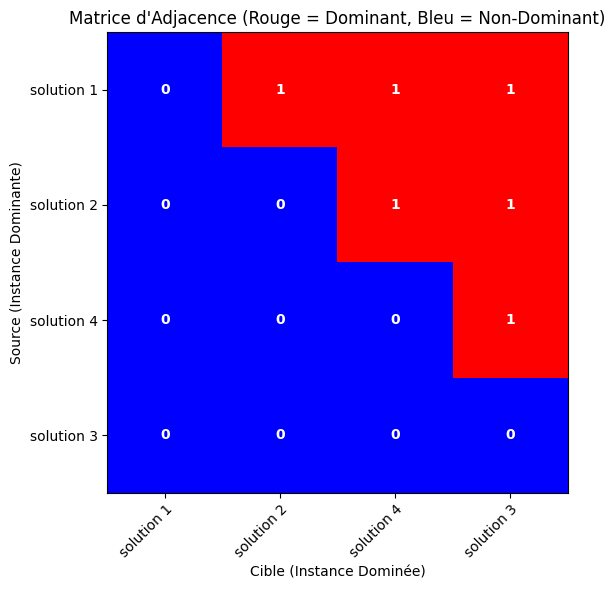

In [69]:
plot_dominance_matrix(adj, [res[0] for res in results])